In [1]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8
import decord
from decord import cpu, gpu
import numpy as np

2023-11-20 08:08:31.890087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 08:08:31.890147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 08:08:31.891462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 08:08:31.898735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 08:08:33.163514: W tensorflow/comp

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
def get_video(video_path, fps=30):
        # If fixed width and height are required, VideoReader takes width and height as arguments.
        video_reader = decord.VideoReader(str(video_path), num_threads=1, ctx=cpu(0))
        decord.bridge.set_bridge('torch')
        vlen = len(video_reader)
        original_fps = video_reader.get_avg_fps()
        num_frames = int(vlen * fps / original_fps)
        # num_frames = min(self.max_num_frames, num_frames)
        frame_idxs = np.linspace(0, vlen, num_frames, endpoint=False).astype(np.int_)
        video = video_reader.get_batch(frame_idxs).byte()
        video = video.permute(0, 3, 1, 2)
        return video

In [4]:
video = get_video('/shared/shang/datasets/nextqa/videos/12682618843.mp4')
video.shape

torch.Size([1459, 3, 360, 640])

In [5]:
import torchvision.transforms as T
transform = T.ToPILImage()
img = transform(video[800])
sampling_rate = 5
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

In [6]:

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
img = transform(video[800])
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["the dog holding a toy bear while chewing on a bone"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

zipped_list = [round(p.item(), 3) for p in text_probs[0]]
print(zipped_list)

Image features shape:  torch.Size([146, 1152]) Text features shape:  torch.Size([4, 1152])
[0.007, 0.128, 0.005, 0.012, 0.0, 0.0, 0.0, 0.001, 0.001, 0.001, 0.0, 0.0, 0.006, 0.186, 0.052, 0.133, 0.016, 0.024, 0.041, 0.035, 0.061, 0.067, 0.012, 0.002, 0.033, 0.026, 0.043, 0.047, 0.041, 0.075, 0.074, 0.127, 0.136, 0.07, 0.104, 0.035, 0.061, 0.011, 0.026, 0.031, 0.084, 0.045, 0.07, 0.389, 0.225, 0.176, 0.317, 0.196, 0.213, 0.225, 0.4, 0.286, 0.269, 0.181, 0.063, 0.221, 0.48, 0.248, 0.473, 0.082, 0.142, 0.426, 0.241, 0.672, 0.326, 0.078, 0.385, 0.216, 0.419, 0.469, 0.288, 0.095, 0.057, 0.0, 0.0, 0.0, 0.082, 0.012, 0.009, 0.015, 0.017, 0.0, 0.041, 0.031, 0.013, 0.028, 0.07, 0.005, 0.025, 0.019, 0.012, 0.015, 0.034, 0.008, 0.179, 0.06, 0.153, 0.006, 0.024, 0.007, 0.251, 0.171, 0.221, 0.114, 0.103, 0.071, 0.173, 0.105, 0.074, 0.156, 0.006, 0.015, 0.148, 0.057, 0.051, 0.033, 0.025, 0.017, 0.019, 0.044, 0.003, 0.004, 0.008, 0.004, 0.017, 0.012, 0.005, 0.004, 0.007, 0.002, 0.002, 0.006, 0.007, 0.

In [7]:
torch.argmax(text_probs)

tensor(255, device='cuda:0')

In [8]:
text_probs[1][255 % 146]

tensor(0.9033, device='cuda:0', dtype=torch.float16)

In [9]:
raw_image = images[109]

In [10]:
from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device)
# preprocess the image
# vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
# generate caption
model.generate({"image": image})
# ['a large fountain spewing water into the air']

/home/shang/miniconda3/envs/vid_vqa/lib/python3.11/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(
100%|██████████| 2.50G/2.50G [01:01<00:00, 43.5MB/s]


['a black dog laying on top of a bed next to a stuffed animal']

In [11]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device)
# ask a random question.
question = "Describe all the objects in this image."
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
question = txt_processors["eval"](question)
model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")

100%|██████████| 1.35G/1.35G [00:31<00:00, 46.2MB/s]


['cat and hat']

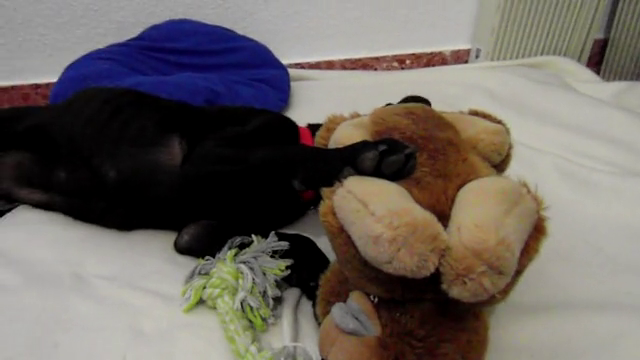

In [11]:
images[21]

In [57]:

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

filenames = [
    'apple-ipod.jpg',
    'apple-blank.jpg',
    'cold_drink.jpg',
    'hot_drink.jpg',
    'caffeine.jpg',
    'siglip.jpg',
    'authors.jpg',
    'robosign.jpg',
    'cow_beach.jpg',
    'cow_beach2.jpg',
    'mountain_view.jpg',]

#@title Load and embed images
images = [Image.open("./data/" + fname) for fname in (filenames)]

labels_list = ["a cow in a tuxedo"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

zipped_list = list(zip(filenames, [round(p.item(), 3) for p in text_probs[0]]))
print(zipped_list)

Image features shape:  torch.Size([4, 1152]) Text features shape:  torch.Size([1, 1152])
[('robosign.jpg', 0.0), ('cow_beach.jpg', 0.001), ('cow_beach2.jpg', 0.99), ('mountain_view.jpg', 0.0)]


In [ ]:
def get_video(self, video_path):
        # If fixed width and height are required, VideoReader takes width and height as arguments.
        video_reader = decord.VideoReader(str(video_path), num_threads=1, ctx=cpu(0))
        decord.bridge.set_bridge('torch')
        vlen = len(video_reader)
        original_fps = video_reader.get_avg_fps()
        num_frames = int(vlen * self.fps / original_fps)
        num_frames = min(self.max_num_frames, num_frames)
        frame_idxs = np.linspace(0, vlen, num_frames, endpoint=False).astype(np.int)
        video = video_reader.get_batch(frame_idxs).byte()
        video = video.permute(0, 3, 1, 2)
        return video